In [1]:
import sys
import os

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np

sys.path.append(os.getcwd())
from load_data import *
from plotting_tools import *

sys.path.append('../3_score/')
from optimize import Scores

In [7]:
data_set_dir = '/scratch/PI/rondror/docking_data/CDK2/'   
   
rmsd_file = 'rmsd.csv'
ligands_dir = data_set_dir + 'ligands/'
grids_dir = data_set_dir + 'grids/'
glide_dir = data_set_dir + 'glide/'
crystal_fp_file = data_set_dir + 'structure_fingerprints/ifp.fp'
docking_fp_dir = data_set_dir + 'docking_fingerprints/'

#crystal_fp_file2 = data_set_dir + 'crystal_fp_jetynan/ifp.fp'
#docking_fp_dir2 = data_set_dir + 'glide_fp_jetynan/'

In [8]:
## useful class specifications:
# Ligand -- attributes: crystal (currently not used/none), poses (dict of pose_num:pose).
# Pose -- attributes: rmsd (float), fp (Fingerprint, num (integer), gscore (float)
# FuzzyFingerPrint -- attributes: pdb, feats (dict of residue name:interaction list).

# crystals: maps structures to Poses, 
#           e.g., crystals['4LDO'] = Pose(rmsd=0, fingerprint, num=0, gscore=0)
# glides:   maps ligand_struct, grid_struct to Ligands, 
#           e.g., glides['4LDO']['4LDO'] = Ligand(...)

## STEP 1:
## load in the crystal structures, docking results, and fingerprints
(crystals, glides) = load_data(
    data_set_dir, rmsd_file, ligands_dir, grids_dir, glide_dir, crystal_fp_file, docking_fp_dir)

#(crystals2, glides2) = load_data(
#    data_set_dir, rmsd_file, ligands_dir, grids_dir, glide_dir, crystal_fp_file2, docking_fp_dir2)

Found 17 grids
Found 17 ligands
Loading crystal structures...
Crystal structure fingerprint file not found.
Loading docking results...
Loading glidescores...
All ligands and structures successfully docked. Nice!
Loading rmsds...
289 of 289 ligands failed to fingerprint.


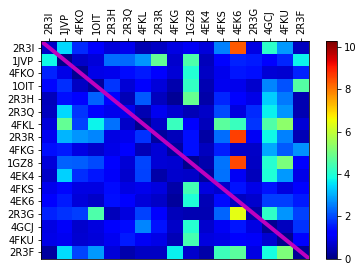

In [9]:
## STEP 2:
## visualize docking results

# in the heatmaps, each row is a structure and each column is a ligand

get_ipython().magic(u'matplotlib inline')

max_num_poses = 50

# this shows the rmsds of glide's top ranked poses (pose 0)
#top_rmsd_matrix = top_pose(glides)
#heatmap(top_rmsd_matrix, glides)

# this shows the losest rmsd in the first 'max_num_poses' poses
best_rmsd_matrix = best_pose(glides, max_num_poses)
heatmap(best_rmsd_matrix, glides)

In [ ]:
## STEP 3:
## pick 1 receptor structure to use for all ligands
## filter ligands that are poorly docked

rmsd_filter = lambda x: x < 2
best_structure, filtered_ligands, ave_rmsd = get_structure_and_ligands(best_rmsd_matrix, rmsd_filter, glides.keys())

print 'The best structure is ' + best_structure
print str(len(filtered_ligands)) + ' of ' + str(len(glides.keys())) + ' ligands were docked well:'
print filtered_ligands
print 'with an average best rmsd of ' + str(ave_rmsd)[:5]

In [ ]:
## STEP 4:
## score all pairs of ligands

# optional arguments: overlap (function) and weights (dictionary of interaction_index to weight)
scores = Scores(glides, crystals, filtered_ligands, best_structure, max_num_poses)

In [ ]:
scores2 = Scores(glides2, crystals2, filtered_ligands, best_structure, max_num_poses)

In [ ]:
## STEP 5:
## plot results

# final_rmsds maps a ligand to its final_rmsd
final_rmsds = plot_final_rmsds(scores,'final')#,scores2,'new h bonds', show_glide=False)

In [ ]:
(worst_lig, worst_rmsd) = final_rmsds[np.argmax([i[1] for i in final_rmsds])]
print worst_lig, worst_rmsd

In [ ]:
#worst_lig='4EK4'

## STEP 6:
## look at the final scores for all poses of the worst ligand

## for our method to work repeatably and reliably,
## there needs to be a strong correlation in these plots

plot_scores_vs_rmsds(worst_lig, scores, lab=worst_lig)#, scores2=scores2, lab2='new h')

In [ ]:
## STEP 7: 
## look through pairs involving worst_lig

l1 = worst_lig
(l2, next_worst_rmsd) = final_rmsds[np.argmax([i[1] if i[1] != worst_rmsd else 0 for i in final_rmsds])]

print l1, l2

In [ ]:
## STEP 8: debug the worst pair

get_ipython().magic(u'matplotlib inline')

plot_all_poses(l1, l2, scores, l1 + ' ' + l2)#, scores2, label2)

In [ ]:
## use this block to extract interesting pairs from the plot above

# l1 pose num, l2 pose num, rmsd1, rmsd2, score

bad_rmsd = lambda r1,r2: (r1+r2)/2.0 >= 2
good_rmsd = lambda r1,r2: (r1+r2)/2.0 <= 1
good_score = lambda score: score >= 50
combo = lambda rmsd, score: score and rmsd

# output: p1, p2, r1, r2, score(p1,p2)
bad_pairs = scores.get_filtered_pose_pairs(l1, l2, bad_rmsd, good_score, combo)
bad_pairs.sort(key=lambda x: x[4])
bad_pairs.reverse()

good_pairs = scores.get_filtered_pose_pairs(l1, l2, good_rmsd, good_score, combo)
good_pairs.sort(key=lambda x: x[4])
good_pairs.reverse()

print l1, l2
print 'Bad pairs:'
for i in range(min(5, len(bad_pairs))):
    print bad_pairs[i]
print 'Good pairs:'
for i in range(min(5, len(good_pairs))):
    print good_pairs[i]

In [ ]:
(bad_score,  bad_interactions)  = scores.get_interactions(l1, l2, bad_pairs[0][0],  bad_pairs[0][1])
(good_score, good_interactions) = scores.get_interactions(l1, l2, good_pairs[0][0], good_pairs[0][1])
(true_score, true_interactions) = scores.get_interactions(l1, l2, -1, -1)

# returns list of tuples: (arg1_strength - arg2_strenth, res, interaction_type)
explore_1 = scores.find_mismatched_interactions(true_interactions, good_interactions)
explore_2 = scores.find_mismatched_interactions(true_interactions, bad_interactions)

explore_1.sort(key=lambda x: abs(x[0]), reverse=True) # sort on absolute value of the mismatch
explore_2.sort(key=lambda x: x[0])

print 'Biggest mismatches between the good pose and the crystal pose'
for i in range(10):
    print explore_1[i]
print '--------'
print 'Biggest negative mismatches between the bad pose and the crystal pose'
for i in range(10):
    print explore_2[i]